In [1]:
# Make sure to upgrade TensorFlow to 2.7.0!!!
# conda activate PIC16B
# pip install tensorflow==2.7.0

# First we need to read in the required packages
import cv2,os
import numpy as np
# from tensorflow.keras.utils import np_utils
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.7.0


# §1. Data Visualization

* Our data set consists of images of faces with masks and also images of faces without masks. For images of faces with masks, the majority of images in our old data set used to be images of simulated masked faces. To make our model more valid and convincing, we have deleted all simulated masked faces and added many more images of real faces with masks.   
* Our data set now has 1600 images for faces with masks and 951 images for faces without masks. 
* The following will be visualizations of some examples from our data set. 

**Here are some of the examples of images of faces without masks**

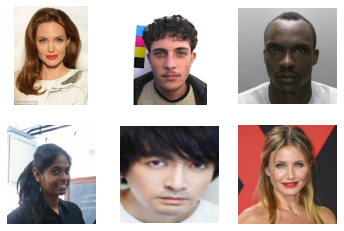

In [12]:
# List of file names
nomasks_list1 = ["data/without_mask/23.jpg", 
               "data/without_mask/29.jpg", 
               "data/without_mask/96.jpg", 
               "data/without_mask/22.jpg",
               "data/without_mask/0_0_zhangluyi_0082.jpg",
               "data/without_mask/74.jpg"]

# Loop through all images, display them
for i in range(6):   
    ax = plt.subplot(2, 3, i + 1)
    # read the image and show it 
    plt.imshow(mpimg.imread(nomasks_list1[i]))
    plt.axis("off")

#### Here are some of the examples of images of faces with masks

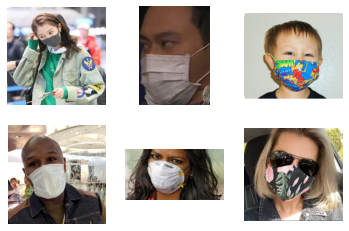

In [10]:
# List of file names
masks_list1 = ["data/with_mask/000 copy 36.jpg", 
               "data/with_mask/0_0_0 copy 21.jpg", 
               "data/with_mask/2398.png", 
               "data/with_mask/with_mask381.jpg",
               "data/with_mask/with_mask316.jpg",
               "data/with_mask/0502.png"]

# Loop through all images, display them
for i in range(6):   
    ax = plt.subplot(2, 3, i + 1)
    # read the image and show it 
    plt.imshow(mpimg.imread(masks_list1[i]))
    plt.axis("off")

<h1>§2. Data Preprocessing</h1>

Now we will define a function that can be used to process our data before training our model 

In [13]:
def DataPreprocess(data_path):
    """
    This function will loop through the data set, preprocess each image
    The input is the path to the data set
    The output will be images and targets in array form
    """
    # Create an empty dictionary to store data
    data_path  = data_path
    categories = ['without_mask', 'with_mask']
    # labels: without_mask, with_mask
    labels = [i for i in range(0, len(categories))]
    # Create an empty dictionary with keys = labels
    label_dict = dict(zip(categories,labels))
    print(label_dict)
    print(categories)
    print(labels)
    # Now loop through the datasets, preprocess each image, 
    # and append the preprocessed image to the empty dictionary created above
    img_size=100
    data=[]
    target=[]
    for category in categories:
        # Construct path to each folder ('without_mask', 'with_mask')
        folder_path=os.path.join(data_path,category)
        img_names=os.listdir(folder_path)
        # Remove ".DS_Store" from the list of image names
        if '.DS_Store' in img_names:
            img_names.remove('.DS_Store')
        # Loop through images in each folder
        for img_name in img_names:
            img_path=os.path.join(folder_path,img_name)
            img=cv2.imread(img_path)
            try:                
                # Resizing the gray scale into 100x100, since we need a fixed common size for all the images in the dataset           
                resized=cv2.resize(img,(img_size,img_size))
                # appending the image and the label(categorized) into the list (dataset)
                data.append(resized)
                target.append(label_dict[category])
            except Exception as e:
                print(img_name)
                print('Exception:',e)
                #if any exception rasied, the exception will be printed here.
   
    # now in this part we convert the images and targets into array form, 
    data=np.array(data)
    target=np.array(target)
    return data, target

Now we will preprocess the data set that we will be used to train the model

In [16]:
data, target = DataPreprocess("data")

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


Let us see what is the baseline performance 

In [17]:
# baseline performance
sum(target)/len(target)

0.6272050176401411

After preprocessing out data, we need to split data into training and testing sets before buidling and training our model 

In [19]:
# Split data into training & testing sets
train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

<h1>§3. Data Augmentation</h1>

Since we want to add some data augmentation layers to our model, we will first experiment wil these layers. 
First, we will create a tf.keras.layers.RandomFlip() layer.
Then we will make a plot of the original image and also when RandomFlip() has been applied.

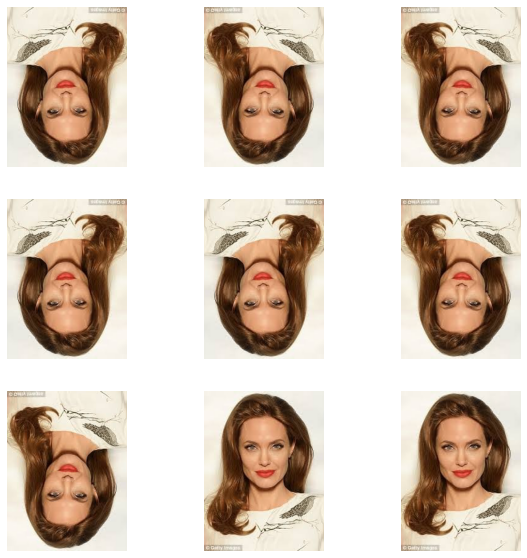

In [20]:
RandomFlip = tf.keras.layers.RandomFlip()
plt.figure(figsize=(10, 10))
image = mpimg.imread("data/without_mask/23.jpg")
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = RandomFlip(tf.expand_dims(image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Then we will create a tf.keras.layers.RandomRotation() layer and make a plot of the original image and also when RandomRotation() has been applied.

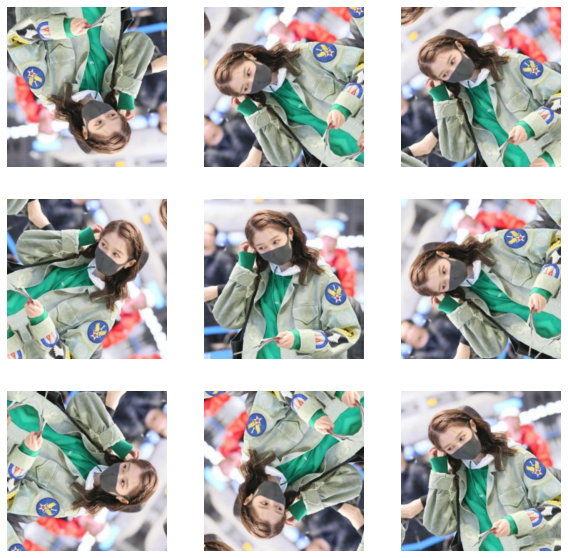

In [21]:
RandomRotation = tf.keras.layers.RandomRotation(0.5)
plt.figure(figsize=(10, 10))
image = mpimg.imread("data/with_mask/000 copy 36.jpg")
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = RandomRotation(tf.expand_dims(image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

<h1>§4. Machine Learning Model</h1>

We will create a tf.keras.Sequential model using both a preprocessor, data augmentation layers, and also some of layers that we have discussed in class

In [27]:
"""
In our model we include:
1. a preprocessor
2. data augmentation: randomly flipping & rotating the images
3. two convolutional 2D layers
4. two max pooling layers
5. two dropout layers to avoid overfitting 
6. a flatten layer
7. and finally two dense layers to match the number of classes in the output
"""

# create a preprocessing layer
i = tf.keras.Input(shape=(100, 100, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(i)
preprocessor = tf.keras.Model(inputs = [i], outputs = [x])

model = tf.keras.Sequential([
    # preprocessing
    preprocessor,
    # data augmentation
    layers.RandomFlip('horizontal'), 
    layers.RandomRotation(0.05),
    # The first CNN layer is a Convolution layer of a kernel size 3*3
    # It learns the base features and applies'relu' nonlinear transformation.
    # Also specifying the input shape here to be 100
    layers.Conv2D(100,(3,3), activation=layers.LeakyReLU(), input_shape=data.shape[1:]),
    # MaxPooling2D((2, 2)) 2*2 the size of window to find the max
    layers.MaxPooling2D((2, 2)),
    # layers.Dropout(0.5) force the model to not fit too closely, help relieve overfitting
    layers.Dropout(0.5),
    # The second convolution layer
    layers.Conv2D(100,(3,3), activation=layers.LeakyReLU()),
    # MaxPooling layer
    layers.MaxPooling2D((2, 2)),
    # Flatten layer to stack the output convolutions from second convolution layer
    layers.Flatten(),
    # layers.Dropout(0.5) force the model to not fit too closely, help relieve overfitting
    layers.Dropout(0.5),
    # Dense layer of 25 neurons
    layers.Dense(25, activation=layers.LeakyReLU()),
    layers.Dense(2,activation='softmax')
])

In [28]:
model.build(data.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 100, 100, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 100, 100, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 100, 100, 3)      0         
 tation)                                                         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 100)       2800      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 100)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 49, 100)       0

Now we will train model and plot the history of the accuracy on both the training and validation sets. 

In [29]:
# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# from_logits=True compute softmax when evaluting loss function
# metrics=['accuracy'] want to see how accurate on the data

# fit the model on 80% of the training set, evaluate on the rest
history = model.fit(train_data,
                     train_target, 
                     epochs=20,
                     validation_split=0.2)

Epoch 1/20


C:\Users\qdjyj\anaconda3\envs\PIC16B\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


58/58 [==============================] - 36s 601ms/step - loss: 0.7413 - accuracy: 0.7881 - val_loss: 0.3014 - val_accuracy: 0.9020
Epoch 2/20
58/58 [==============================] - 35s 601ms/step - loss: 0.3134 - accuracy: 0.8764 - val_loss: 0.2454 - val_accuracy: 0.9237
Epoch 3/20
58/58 [==============================] - 35s 611ms/step - loss: 0.2740 - accuracy: 0.8943 - val_loss: 0.2634 - val_accuracy: 0.9172
Epoch 4/20
58/58 [==============================] - 41s 709ms/step - loss: 0.2244 - accuracy: 0.9112 - val_loss: 0.3018 - val_accuracy: 0.9107
Epoch 5/20
58/58 [==============================] - 43s 746ms/step - loss: 0.2025 - accuracy: 0.9205 - val_loss: 0.2423 - val_accuracy: 0.9172
Epoch 6/20
58/58 [==============================] - 45s 774ms/step - loss: 0.1818 - accuracy: 0.9286 - val_loss: 0.3761 - val_accuracy: 0.8845
Epoch 7/20
58/58 [==============================] - 44s 758ms/step - loss: 0.1813 - accuracy: 0.9325 - val_loss: 0.3218 - val_accuracy: 0.8954
Epoch 8/20

We want to visualize the training history.

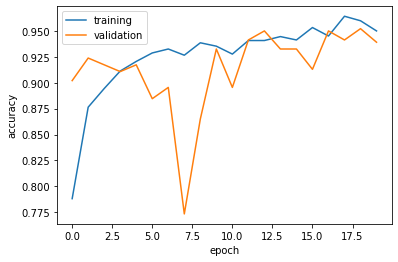

In [30]:
"""
Our results proved to be pretty precise and there
is no apparent sign of overfitting.
"""
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy") # gca: get current axis 
plt.legend()

Now we would want to evaluate the accuracy of the model on the test dataset

In [31]:
print(model.evaluate(test_data,test_target))

8/8 [==============================] - 1s 146ms/step - loss: 0.1290 - accuracy: 0.9453
[0.1290377378463745, 0.9453125]


<h1>§5. Testing Model on data sets of different racial group</h1>

* We now want to analyze whether our algorithm works as well on the faces of Black people as it does on the faces of East Asian or white people to test if our algorithm is biased  
* We have separately prepared three data sets corresonding to black people, East Asia people, and white people. We will preprocess each data set and then test our model.

In [34]:
categories = ['without_mask', 'with_mask']

In [47]:
def testing(data_path):
    """
    This function will preprocess the data set, test the model on the data set, and create visualization
    """
    # preprocess the data
    data_test, target_test = DataPreprocess(data_path)
    # Test model on the data set
    print(model.evaluate(data_test, target_test))
    # visualize
    y_pred = model.predict(data_test)
    labels_pred = y_pred.argmax(axis = 1)
    plt.figure(figsize=(10,10))
    for i in range(30):
        if i < 15:
            plt.subplot(6,5,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(data_test[i])
            plt.xlabel(categories[labels_pred[i]])
        else:
            plt.subplot(6,5,i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(data_test[i+25])
            plt.xlabel(categories[labels_pred[i+25]])

#### 1. Data set containing faces of black people wearing masks and not wearing masks

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]
2/2 [==============================] - 0s 141ms/step - loss: 0.7396 - accuracy: 0.7966
[0.7395762801170349, 0.7966101765632629]


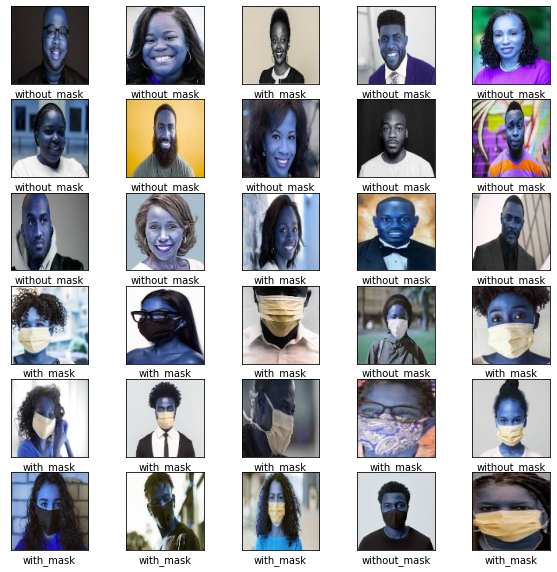

In [49]:
testing("data/Testing_Black")

#### 2. Data set containing faces of East Asia people wearing masks and not wearing masks

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]
2/2 [==============================] - 0s 128ms/step - loss: 0.1395 - accuracy: 0.9167
[0.13954110443592072, 0.9166666865348816]


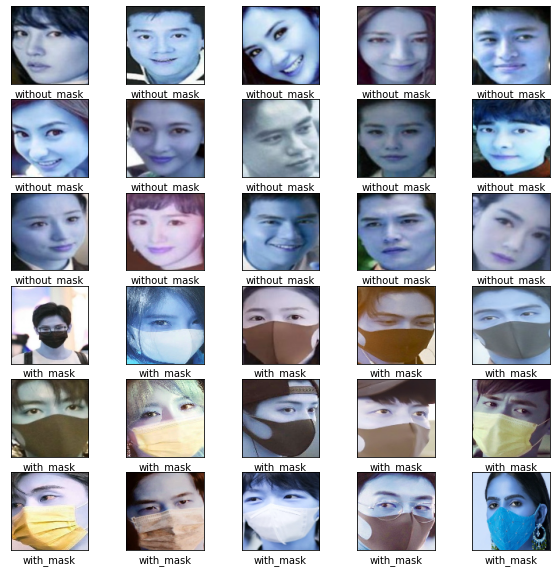

In [54]:
testing("data/Testing_Asian")

#### 3. Data set containing faces of White people wearing masks and not wearing masks

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]
2/2 [==============================] - 0s 107ms/step - loss: 0.5628 - accuracy: 0.8364
[0.5628120303153992, 0.8363636136054993]


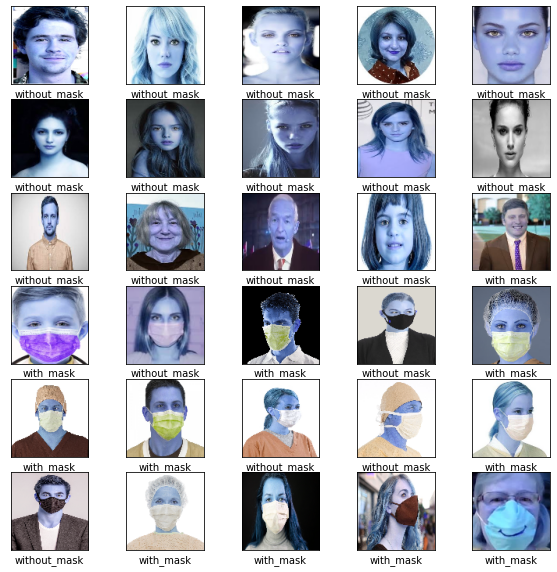

In [57]:
testing("data/Testing_White")

We can see that our model performs best on Asian with around 92% accuracy, and then around 84% accuracy on White people, then around 80% on Black people. Our model indeed appears to have different levels of accuracy on people with different race. One reason might causing this issue is because the percentage of training data we have for people with different race. The highest percentage of our training data is from Asian, and then the second group is White people. Looking through our training data set, we only have a limited amount of images of black. The lacking of images of black people in the data set is one limitation of our project, and we believe incorporating more data of black people probably will he

<h1>§6. Limitations & Future Directions</h1>

- The current model is limited to classifying **static** images of people with and without masks. In reality, a face mask classifier would receive **dynamic**, **online** inputs.
    - Future direction: Develop an algorithm that can signal whether someone is wearing a mask real time in a video. This could be done by repeatedly deploying the current algorithm on each frame of the video.

- Currently, the model can only tell apart masks vs. without masks. But, it cannot differentiate different types of facial covering (e.g., masks, bandanas, scarves). As we know, masks are more effective in preventing the spread of COVID-19 than other types of facial coverings. 
    - Future direction: Develop a face mask **detector**, as opposed to **classifier**. This may benefit from using OpenCV.

- Some people cannot wear masks due to medical/religious reasons. 
    - Future direction: Although it would be hard to develop an algorithm that can tell if someone has a medical condition  that makes them unable to wear masks, we know that certain populations just cannot wear masks (e.g., children < 2yrs). So, it might be worthwhile to develop a face mask detector that does not display warnings when a toddler is not wearing a mask. This would involve training the algorithm to differentiate facial features on top of having masks or not.